In [2]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from plotly import graph_objects as go
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('src/spam.csv', encoding = "ISO-8859-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
# dropping useless columns with too many missing values, rename columns and 
df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)
df = df.rename(columns={"v1":"target", "v2":"content"})
df['target'] = df['target'].apply(lambda x : 0 if x == "ham" else 1)
df.head()

,target,content
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# features and target
X = df['content']
y = df['target']

In [6]:
# Train Test Split
xtrain, xval, ytrain, yval = train_test_split(X, y, test_size=0.2)

In [7]:
# Batch
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

In [8]:
# Downloading pre trained model
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2",
                           input_shape=[], dtype=tf.string, trainable=True)

In [9]:
# create a model with pre trained layer, add a Dense layer (relu) and a Dense layer (sigmoid) on output
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [10]:
# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [11]:
#fit the model
history = model.fit(train.shuffle(10000).batch(512),
                    epochs=20,
                    validation_data=val.batch(512),
                    )

Epoch 1/20
9/9 [==============================] - 8s 737ms/step - loss: 0.6307 - accuracy: 0.7752 - val_loss: 0.5811 - val_accuracy: 0.8637
Epoch 2/20
9/9 [==============================] - 5s 460ms/step - loss: 0.5326 - accuracy: 0.8914 - val_loss: 0.4949 - val_accuracy: 0.8753
Epoch 3/20
9/9 [==============================] - 5s 447ms/step - loss: 0.4449 - accuracy: 0.9013 - val_loss: 0.4157 - val_accuracy: 0.8825
Epoch 4/20
9/9 [==============================] - 4s 421ms/step - loss: 0.3654 - accuracy: 0.9127 - val_loss: 0.3456 - val_accuracy: 0.8942
Epoch 5/20
9/9 [==============================] - 4s 423ms/step - loss: 0.2965 - accuracy: 0.9325 - val_loss: 0.2860 - val_accuracy: 0.9157
Epoch 6/20
9/9 [==============================] - 4s 429ms/step - loss: 0.2395 - accuracy: 0.9484 - val_loss: 0.2362 - val_accuracy: 0.9283
Epoch 7/20
9/9 [==============================] - 5s 441ms/step - loss: 0.1933 - accuracy: 0.9625 - val_loss: 0.1948 - val_accuracy: 0.9489
Epoch 8/20
9/9 [====

In [12]:
# return after sigmoid layer and tranform as int to have binary pred 0 or 1
ypred_train = (model.predict(xtrain) > 0.5).astype("int32")
ypred_val = (model.predict(xval) > 0.5).astype("int32")

35/35 [==============================] - 4s 41ms/step


In [13]:
#print accuracy on train and validation set
print(f"accuracy score on train set : {accuracy_score(ytrain, ypred_train)}")
print(f"accuracy score on validation set : {accuracy_score(yval, ypred_val)}")

accuracy score on train set : 0.9968588736818488
accuracy score on validation set : 0.9829596412556054


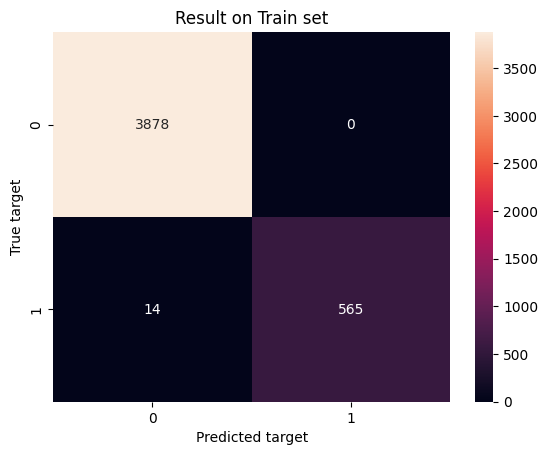

In [14]:
#plot confusion matrix for test
conf = confusion_matrix(ytrain, ypred_train)
sns.heatmap(conf, annot=True, fmt='d')
plt.ylabel('True target')
plt.xlabel('Predicted target')
plt.title('Result on Train set')
plt.show()

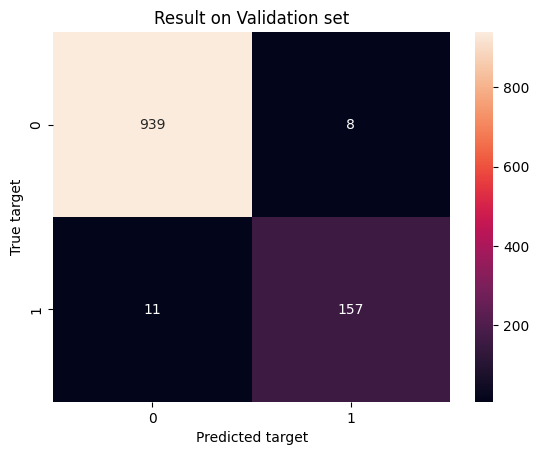

In [15]:
#plot confusion matrix for val
conf = confusion_matrix(yval, ypred_val)
sns.heatmap(conf, annot=True, fmt='d')
plt.ylabel('True target')
plt.xlabel('Predicted target')
plt.title('Result on Validation set')
plt.show()

On a une precison  avec 8 faux positif (vrai message considéré en spam) et un recall avec 11 faux négatif (spam considéré en vrai message)

In [16]:
#plot history of the loss and accuracy (training and val)
color_chart = ["red", "blue", "#FF6692", "#19D3F3"]

history_lstm = history.history
fig = go.Figure(data=[
                      go.Scatter(
                          y=history_lstm["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history_lstm["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          )),
                      go.Scatter(
                          y=history_lstm["accuracy"],
                          name= "Training accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[2]
                          )),
                     go.Scatter(
                          y=history_lstm["val_accuracy"],
                          name= "Val accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[3]
                          ))
])
fig.update_layout(
    title='Training and val (loss and accuracy) across epochs',
    xaxis_title='epochs',
    yaxis_title='accuracy and loss'    
)
fig.show()

Sans surprise le modèle entrainé à une 'accuracy' très élevé dès la première epoch, le modèle étant déjà pré-entrainé, il s'ajuste sur les nouvelles données.

Le modéle s'entraine très bien sur le train, accuracy à 0.996 , 0.982 sur le test.

Le modèle prétrainée donne un meilleur résultat avec prédiction "spam/ham" à 98.2%